In [1]:
import torch
import sys
sys.path.append("../")
import cumulant_analyzer
from cumulant_analyzer import CumulantAnalyzer, to_numpy
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import plot_utils
from plot_utils import plot_comparison, plot_stats
from IPython.display import display, Markdown
import pandas as pd

import warnings
warnings.filterwarnings(
    "ignore",
    message="You are using `torch.load` with `weights_only=False`.*",
    category=FutureWarning,
)

from transformers.utils.logging import disable_progress_bar
disable_progress_bar()

g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
ds = load_dataset("NeelNanda/pile-10k")['train']
filtered_indices = np.load('filtered_indices.npy')
max_length = 256

In [3]:
test_indx = 686
prompt_indx = filtered_indices[test_indx]
test_sequence = ds['text'][prompt_indx].strip()
analyzer = CumulantAnalyzer(model_name='gpt2-large', max_length = 256)
stats = analyzer.compute_stats(test_sequence)
shuffled_stats = analyzer.compute_stats(test_sequence, shuffled = True)

## For a single prompt

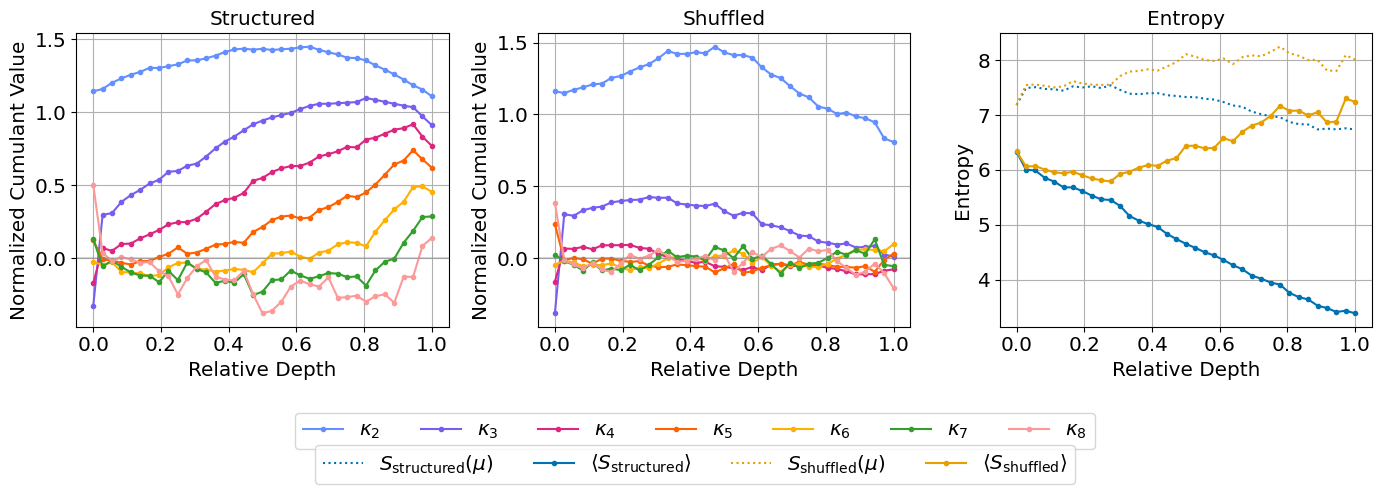

In [4]:
fig = plot_comparison(stats, shuffled_stats)

plt.savefig(f'../plots/structured_shuffled.png', bbox_inches='tight')
plt.show()

## Consistency across prompts

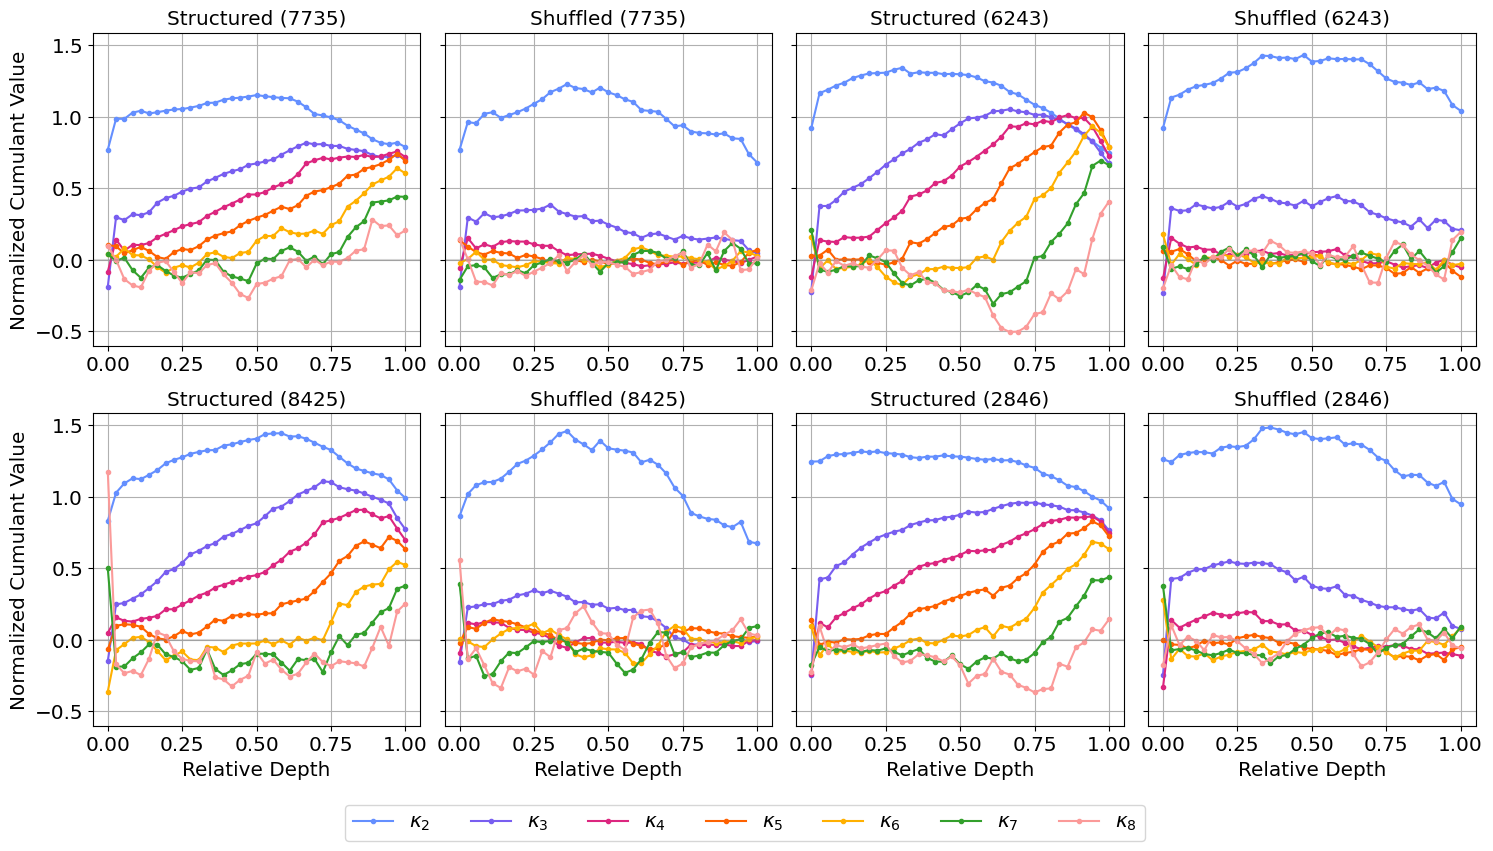

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8), sharey = True)
for qq, indx in enumerate(np.random.choice(2244, 4)): 
    prompt_indx = filtered_indices[indx]
    test_sequence = ds['text'][prompt_indx].strip()
    stats = analyzer.compute_stats(test_sequence)
    shuffled_stats = analyzer.compute_stats(test_sequence, shuffled = True)
    plot_stats(stats, axes[qq//2][qq%2*2], title = f"Structured ({prompt_indx})")
    plot_stats(shuffled_stats, axes[qq//2][qq%2*2 + 1], title = f"Shuffled ({prompt_indx})")
for qq in range(8):
    if qq % 4 != 0: axes[qq//4][qq%4].set_ylabel(None)
for qq in range(8):
    if qq//4 == 0: axes[qq//4][qq%4].set_xlabel(None)
        
handles_psim, labels_psim = axes[0, 0].get_legend_handles_labels()
fig.legend(handles_psim, labels_psim, loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol = 7,  fontsize = "x-large")
plt.tight_layout()
plt.savefig(f'../plots/manyprompts.png', bbox_inches='tight')
plt.show()
    

## Finding histogram of $\delta X$ (and verifying the cumulants)
1. Lets take a layer = 20, test_indx = 686
2. Find the histogram of $\delta X$
3. Find the cumulants and cerify that it matches the average of cumulants

Here we verify if the cumulants of $\delta X$ is related to the average token wise cumulants, i.e.,
$$\sum_{i} \kappa_n(\delta x_i) = \kappa_n(\sum_i \delta x_i) = \kappa_n(\delta X)$$

In [6]:
test_indx = 686
prompt_indx = filtered_indices[test_indx]
test_sequence = ds['text'][prompt_indx].strip()

In [7]:
mc_stats = analyzer.do_monte_carlo(test_sequence, LNUM = 20, n_sims = 200_000_000, n_bins = 1_000)  
shuffled_mc_stats = analyzer.do_monte_carlo(test_sequence, shuffled = True, LNUM = 20, n_sims = 200_000_000, n_bins = 1_000)  

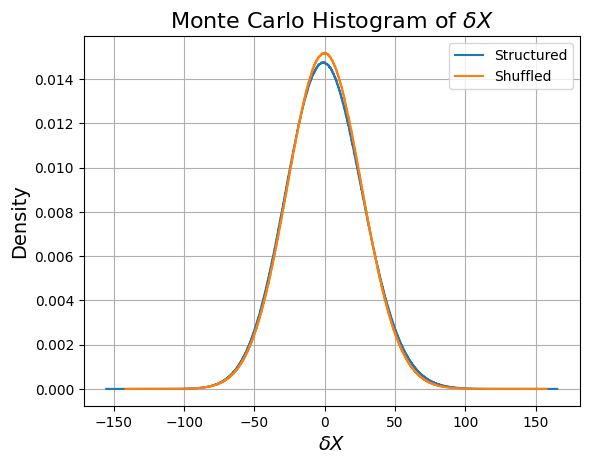

In [8]:
plt.step(mc_stats['centers'], mc_stats['hist'], where='mid', label = "Structured")
plt.step(shuffled_mc_stats['centers'], shuffled_mc_stats['hist'], where='mid', label = "Shuffled")
plt.legend()
plt.xlabel(r"$\delta X$", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title(r"Monte Carlo Histogram of $\delta X$", fontsize=16)
plt.grid(True)
plt.savefig("../plots/monte_carlo_delta_x.png")
plt.show()

In [9]:
display(Markdown(r"#### Comparing cumulants obtained by simulating $\delta X$ and considering the average of token-wise cumulants"))
df_combined = pd.concat([mc_stats['df'], shuffled_mc_stats['df']], ignore_index=True).round(3)
display(df_combined)

#### Comparing cumulants obtained by simulating $\delta X$ and considering the average of token-wise cumulants

,type,$\kappa_2$ (monte carlo),$\kappa_2$ (avg of tokens),$\kappa_3$ (monte carlo),$\kappa_3$ (avg of tokens),$\kappa_4$ (monte carlo),$\kappa_4$ (avg of tokens)
0,structured,1.432,1.432,0.986,0.981,0.623,0.616
1,shuffled,1.351,1.430,0.238,0.294,-0.015,-0.128


#### Takeaway: The observable $\sum_{i} \kappa_n(\delta x_i)$ can be alternatively obtained by looking at the probability density of $\delta X$

